In [2]:
from __future__ import absolute_import, generators, print_function
import pandas
print(pandas.__version__)


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

0.16.1


In [3]:
import plotly.plotly as py  
import plotly.tools as tls   
from plotly.graph_objs import *

In [4]:
# Create 4 random equity "returns" with 1k ticks each

## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)
print(return_vec.shape)


(4, 1000)


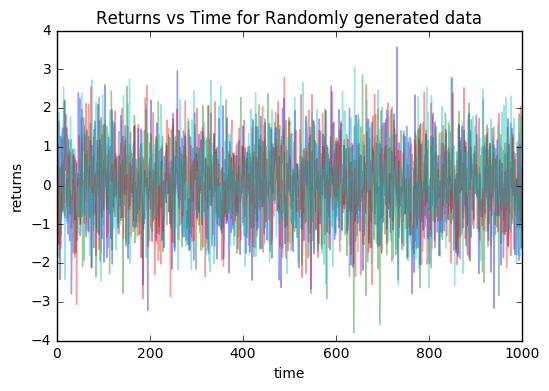

In [5]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
plt.title('Returns vs Time for Randomly generated data')

In [9]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1.
    A rather crude yet simple method.
    '''
    k = np.random.rand(n)
    return k / sum(k)

for i in range(2):
    print(rand_weights(n_assets))

[ 0.1418152   0.32120599  0.15426636  0.38271245]
[ 0.31914912  0.16429232  0.28645334  0.23010522]


In the code you will notice the calculation of the return with:
$$ R = p^T w $$
where $R$ is the expected return, $p^T$ is the transpose of the vector for the mean returns for each time series and w is the weight vector of the portfolio. $p$ is a Nx1 column vector, so $p^T$ turns into a 1xN row vector which can be multiplied with the Nx1 weight (column) vector w to give a scalar result. This is equivalent to the dot product used in the code. Keep in mind that Python has a reversed definition of rows and columns and the accurate NumPy version of the previous equation would be R = w * p.T
Next, we calculate the standard deviation with
$$\sigma = \sqrt{w^T C w}$$
where $C$ is the covariance matrix of the returns which is a NxN matrix. Please note that if we simply calculated the simple standard deviation with the appropriate weighting using std(array(ret_vec).T*w) we would get a slightly different ’bullet’. This is because the simple standard deviation calculation would not take covariances into account. In the covariance matrix, the values of the diagonal represent the simple variances of each asset while the off-diagonals are the variances between the assets. By using ordinary std() we effectively only regard the diagonal and miss the rest. A small but significant difference.
Lets generate the mean returns and volatility for 500 random portfolios:

In [10]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio.
    This is where I use markowitz's MPT concepts first.
    '''

    p = np.asmatrix(np.mean(returns, axis=1)) # (1, 4) matrix with mean of return of all stocks
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    # important step for avoiding absurd portfolios
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma


In [11]:
n_portfolios = 1000 # create this many portfolio scenarios
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

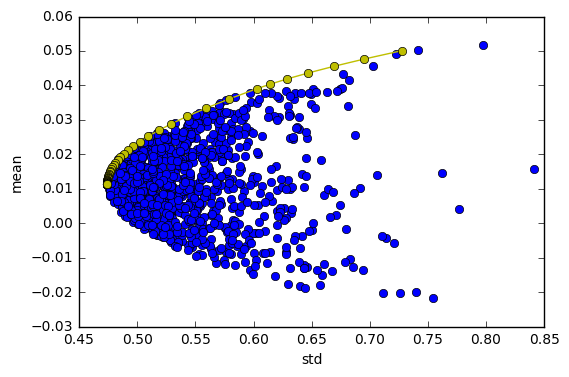

In [13]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [14]:
print(weights)
# Suggests invest to one type of asset. sort of makes sense since highly random data

[[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]


In [15]:
from zipline.utils.factory import load_bars_from_yahoo
end = pd.Timestamp.utcnow()
start = end - 2500 * pd.tseries.offsets.BDay()

data = load_bars_from_yahoo(stocks=['JNJ', 'WFM', 'SPY', 'GSG', 
                                    'GLD', 'TD', 'ETFC'],
                            start=start, end=end)

JNJ
WFM
SPY
GSG
GLD
TD
ETFC


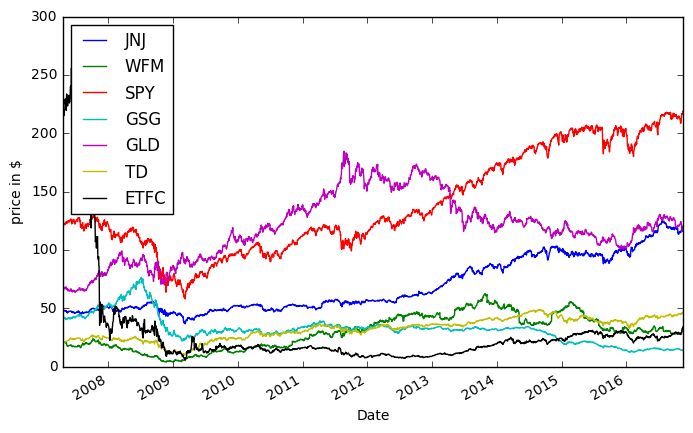

In [16]:
data.loc[:, :, 'price'].plot(figsize=(8,5))
plt.ylabel('price in $')
plt.grid()

In [17]:
import zipline
from zipline.api import (add_history, 
                         history, 
                         set_slippage, 
                         slippage,
                         set_commission, 
                         commission, 
                         order_target_percent)

from zipline import TradingAlgorithm


def initialize(context):
    '''
    Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables.
    
    The context object is passed to all the other methods in your algorithm.

    Parameters

    context: An initialized and empty Python dictionary that has been 
             augmented so that properties can be accessed using dot 
             notation as well as the traditional bracket notation.
    
    Returns None
    '''
    # Register history container to keep a window of the last 100 prices.
    add_history(100, '1d', 'price')
    # Turn off the slippage model
    set_slippage(slippage.FixedSlippage(spread=0.0))
    # Set the commission model (Interactive Brokers Commission)
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
    context.tick = 0
    
def handle_data(context, data):
    '''
    Called when a market event occurs for any of the algorithm's 
    securities. 

    Parameters

    data: A dictionary keyed by security id containing the current 
          state of the securities in the algo's universe.

    context: The same context object from the initialize function.
             Stores the up to date portfolio as well as any state 
             variables defined.

    Returns None
    '''
    # Allow history to accumulate 100 days of prices before trading
    # and rebalance every day thereafter.
    context.tick += 1
    if context.tick < 100:
        return
    # Get rolling window of past prices and compute returns
    prices = history(100, '1d', 'price').dropna()
    returns = prices.pct_change().dropna()
    try:
        # Perform Markowitz-style portfolio optimization
        weights, _, _ = optimal_portfolio(returns.T)
        # Rebalance portfolio accordingly
        for stock, weight in zip(prices.columns, weights):
            order_target_percent(stock, weight)
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass
        
# Instantinate algorithm        
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data)
# Run algorithm
results = algo.run(data)
# results.portfolio_value.iplot(filename='algo_perf', yTitle='Cumulative capital in $', world_readable=True, asDates=True)

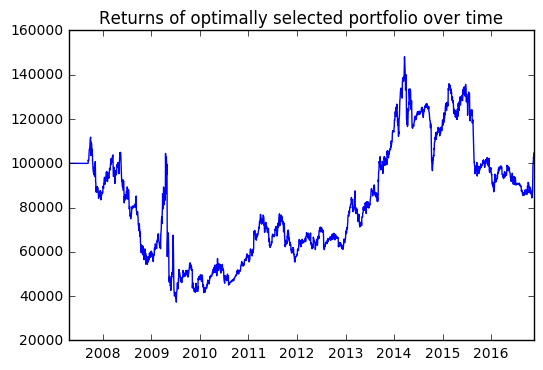

In [18]:

plt.plot(results.portfolio_value)
plt.title('Returns of optimally selected portfolio over time')